# runaurora_v2.ipynb

End-to-end pipeline for Aurora Detection

**Contents:** EDA → Preprocessing → EfficientNetV2-S fine-tuning → Evaluation (AUC) → Submission

*Auto-generated by ChatGPT.*

## 1. Environment & Imports

Install required packages if not present, then import libraries. If running on local, make sure PyTorch and torchvision are installed and compatible with your CUDA.

Run the following cell.

In [1]:
# Uncomment the following to install (colab/local) if needed
!pip install timm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
from tqdm import tqdm

print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


torch: 2.5.1+cu121
cuda available: True
NVIDIA GeForce RTX 4070 Laptop GPU


## 2. Configuration

Set dataset paths, training hyperparameters, and other options. Adjust paths if needed.

In [2]:
# === CONFIG ===
MAIN_FOLDER = r"D:\Rap_Gemastik2\odyssey-aurora-detection"  # <- change if needed
TRAIN_DIR = os.path.join(MAIN_FOLDER, "train")
TEST_DIR = os.path.join(MAIN_FOLDER, "test")
SAMPLE_SUBMISSION = os.path.join(MAIN_FOLDER, "sample_submission.csv")  # if provided

OUTPUT_DIR = os.path.join(MAIN_FOLDER, "runaurora_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
BATCH_SIZE = 8
IMG_SIZE = 384
NUM_EPOCHS = 10
LR = 1e-4
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('Config set. Output dir:', OUTPUT_DIR)

Config set. Output dir: D:\Rap_Gemastik2\odyssey-aurora-detection\runaurora_outputs


## 3. EDA - Build train/test DataFrames from folders

This cell constructs `train_df` and `test_df` from folder structure. `train/label_name/*.jpg` and `test/*.jpg`.

In [3]:
# Build train_df and test_df from folder structure
def build_dataframes(train_dir, test_dir):
    train_rows = []
    for label in sorted(os.listdir(train_dir)):
        label_folder = os.path.join(train_dir, label)
        if os.path.isdir(label_folder):
            for fn in sorted(os.listdir(label_folder)):
                if fn.lower().endswith(('.jpg', '.jpeg', '.png')):
                    train_rows.append({'filename': os.path.join(label_folder, fn), 'label': label})
    train_df = pd.DataFrame(train_rows)
    test_rows = []
    for fn in sorted(os.listdir(test_dir)):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png')):
            test_rows.append({'filename': os.path.join(test_dir, fn)})
    test_df = pd.DataFrame(test_rows)
    return train_df, test_df

train_df, test_df = build_dataframes(TRAIN_DIR, TEST_DIR)
print('Train samples:', len(train_df))
print('Test samples:', len(test_df))
train_df.head()

Train samples: 4610
Test samples: 1153


,filename,label
0,D:\Rap_Gemastik2\odyssey-aurora-detection\trai...,aurora
1,D:\Rap_Gemastik2\odyssey-aurora-detection\trai...,aurora
2,D:\Rap_Gemastik2\odyssey-aurora-detection\trai...,aurora
3,D:\Rap_Gemastik2\odyssey-aurora-detection\trai...,aurora
4,D:\Rap_Gemastik2\odyssey-aurora-detection\trai...,aurora


Classes: 2 ['aurora' 'no_aurora']

Sample counts per class:
label
aurora       2510
no_aurora    2100
Name: count, dtype: int64


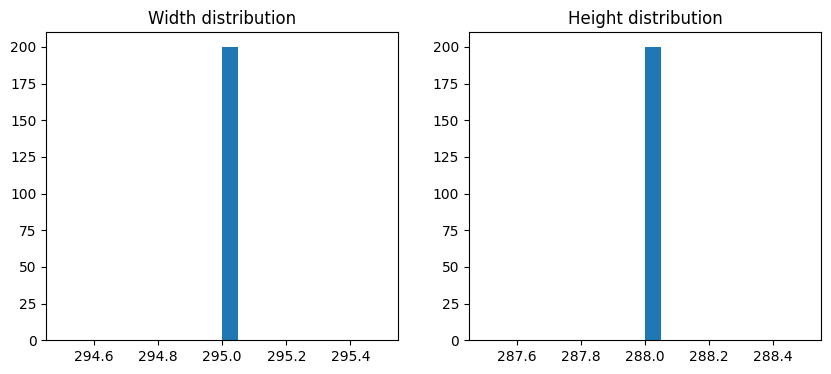

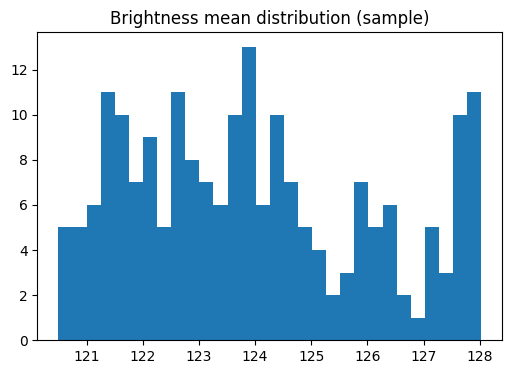

In [4]:
# Quick checks and visualizations
print('Classes:', train_df['label'].nunique(), train_df['label'].unique())
print('\nSample counts per class:')
print(train_df['label'].value_counts())

# Image size distribution (sample up to 200 images to avoid heavy ops)
def img_stats(paths, n=200):
    sizes = []
    means = []
    for p in paths[:min(len(paths), n)]:
        try:
            im = Image.open(p).convert('L')
            sizes.append(im.size)
            means.append(np.array(im).mean())
        except Exception as e:
            print('Error reading', p, e)
    return sizes, means

sizes, means = img_stats(train_df['filename'].tolist(), n=200)
if sizes:
    widths = [s[0] for s in sizes]
    heights = [s[1] for s in sizes]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(widths, bins=20); plt.title('Width distribution')
    plt.subplot(1,2,2)
    plt.hist(heights, bins=20); plt.title('Height distribution')
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(means, bins=30); plt.title('Brightness mean distribution (sample)'); plt.show()

In [5]:
# Display some positives and negatives
def show_examples(df, label=None, n=6):
    if label is None:
        sample = df.sample(min(n, len(df)))
    else:
        sample = df[df['label']==label].sample(min(n, len(df)))
    fig, axes = plt.subplots(1, len(sample), figsize=(15,3))
    for ax, (_, row) in zip(axes, sample.iterrows()):
        try:
            im = Image.open(row['filename']).convert('L')
            ax.imshow(im, cmap='gray')
            ax.set_title(row.get('label',''))
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, 'Err', ha='center')
    plt.show()

# show examples
if 'AURORA' in train_df['label'].unique():
    show_examples(train_df, label='AURORA', n=6)
if 'NO_AURORA' in train_df['label'].unique():
    show_examples(train_df, label='NO_AURORA', n=6)

## 4. Dataset & Transforms

Create PyTorch Dataset and augmentation pipeline. We use realistic augmentations that preserve auroral geometry.

In [6]:
class AuroraDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['filename']
        img = Image.open(img_path).convert('RGB')  # keep 3-channel for models
        if self.transforms:
            img = self.transforms(img)
        if self.is_test:
            return img, img_path  # return path for submission alignment
        label = 1 if row['label'].upper() in ['AURORA','1','TRUE','YES'] else 0
        return img, torch.tensor(label, dtype=torch.float32)

# transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.25, contrast=0.25),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transforms = val_transforms
print('Transforms ready')

Transforms ready


## 5. Train/Validation Split & Loaders

Stratified split by label.

In [7]:
from sklearn.model_selection import train_test_split
if 'label' in train_df.columns:
    train_df['label_bin'] = train_df['label'].apply(lambda x: 1 if str(x).upper()=='AURORA' else 0)
else:
    raise ValueError('train_df must have label column')

train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label_bin'], random_state=SEED)

train_ds = AuroraDataset(train_df, transforms=train_transforms, is_test=False)
val_ds = AuroraDataset(val_df, transforms=val_transforms, is_test=False)
test_ds = AuroraDataset(test_df, transforms=test_transforms, is_test=True)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

print('Train/Val/Test loaders created:')
print('Train:', len(train_ds), 'Val:', len(val_ds), 'Test:', len(test_ds))

Train/Val/Test loaders created:
Train: 3688 Val: 922 Test: 1153


## 6. Model: EfficientNetv2_b0 (pretrained) + head

We use timm to load EfficientNetV2. You can switch to other models (Swin, ConvNeXt) if desired.

In [8]:
def build_model(num_classes=1, pretrained=True):
    model = timm.create_model('tf_efficientnetv2_s_in21k', pretrained=pretrained, num_classes=num_classes)
    return model

model = build_model(num_classes=1, pretrained=True)
model = model.to(DEVICE)
print(model)

D:\Rap_Gemastik2\.venv\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [9]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print('Criterion, optimizer, scheduler set.')

Criterion, optimizer, scheduler set.


## 7. Training Loop (with validation AUC)

Training loop reports loss and validation AUC each epoch. Uses simple early stopping.

In [10]:
criterion = torch.nn.BCEWithLogitsLoss()

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(loader, desc='Train'):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1).float()  # ← tambahkan unsqueeze(1)

        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


def validate(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc='Val'):
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1).float()
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().ravel().tolist())
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    return auc, all_labels, all_probs


best_auc = 0.0
patience = 5
wait = 0
history = {'train_loss':[], 'val_auc':[]}

for epoch in range(NUM_EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===")
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_auc, _, _ = validate(model, val_loader, DEVICE)
    
    scheduler.step(val_auc)
    
    history['train_loss'].append(train_loss)
    history['val_auc'].append(val_auc)
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}")
    
    if not np.isnan(val_auc) and val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pt'))
        print('✅ Saved best model.')
        wait = 0
    else:
        wait += 1
    
    if wait >= patience:
        print('🛑 Early stopping triggered.')
        break

print('🏁 Training finished. Best AUC:', best_auc)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type == "cuda"))



=== Epoch 1/10 ===


Train:   0%|                                 | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.13it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 - Train Loss: 1.4868 | Val AUC: 0.9876
✅ Saved best model.

=== Epoch 2/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:21<00:00,  5.44it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 2 - Train Loss: 0.6460 | Val AUC: 0.9967
✅ Saved best model.

=== Epoch 3/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.19it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 3 - Train Loss: 0.4067 | Val AUC: 0.9928

=== Epoch 4/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:21<00:00,  5.39it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 4 - Train Loss: 0.3789 | Val AUC: 0.9971
✅ Saved best model.

=== Epoch 5/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:21<00:00,  5.36it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 5 - Train Loss: 0.1922 | Val AUC: 0.9973
✅ Saved best model.

=== Epoch 6/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:21<00:00,  5.28it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 6 - Train Loss: 0.1495 | Val AUC: 0.9973
✅ Saved best model.

=== Epoch 7/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.26it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 7 - Train Loss: 0.1366 | Val AUC: 0.9972

=== Epoch 8/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.13it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 8 - Train Loss: 0.1087 | Val AUC: 0.9997
✅ Saved best model.

=== Epoch 9/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.21it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 9 - Train Loss: 0.0872 | Val AUC: 0.9997

=== Epoch 10/10 ===


Train:   0%|                                                                                                      | 0/461 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\1871913772.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.07it/s]
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Epoch 10 - Train Loss: 0.0738 | Val AUC: 0.9998
✅ Saved best model.
🏁 Training finished. Best AUC: 0.999843483210017


## 8. Evaluation & Plots

Load best model, compute ROC curve and show confusion matrix at threshold 0.5.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33820\4170676478.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DE

Loaded best model for evaluation.


Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:22<00:00,  5.27it/s]


Validation AUC: 0.999843483210017


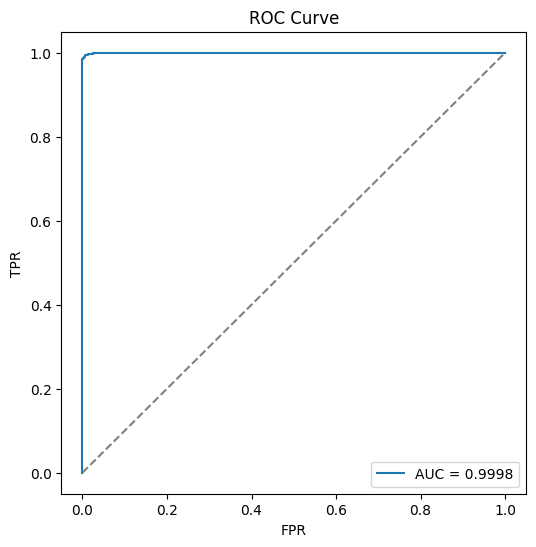

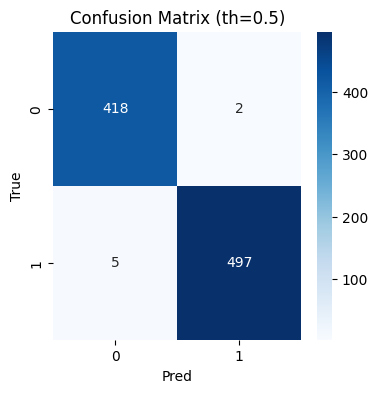

In [11]:
# Load best model weights
best_path = os.path.join(OUTPUT_DIR, 'best_model.pt')
if os.path.exists(best_path):
    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    model.to(DEVICE)
    print('Loaded best model for evaluation.')
else:
    print('Best model not found, using current model for evaluation.')

# Get val labels and probs
val_auc, val_labels, val_probs = validate(model, val_loader, DEVICE)
print('Validation AUC:', val_auc)

# ROC curve
fpr, tpr, thr = roc_curve(val_labels, val_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {val_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# Confusion matrix at threshold 0.5
preds = [1 if p>=0.5 else 0 for p in val_probs]
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (th=0.5)'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

## 9. Test-Time Augmentation (TTA) & Submission

Perform TTA and create submission following `filepath,prob_aurora` matching sample_submission.csv if present.

In [12]:
# Simple TTA: no flip augmentation applied here (dataset returns transformed images).
def tta_predict(model, loader, device):
    model.eval()
    all_probs = []
    all_paths = []
    with torch.no_grad():
        for imgs, paths in tqdm(loader, desc='TTA Predict'):
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_probs.extend(probs.tolist())
            all_paths.extend(paths)
    return all_paths, all_probs

paths, probs = tta_predict(model, test_loader, DEVICE)

# Build submission aligned with sample_submission if exists
if os.path.exists(SAMPLE_SUBMISSION):
    sample_df = pd.read_csv(SAMPLE_SUBMISSION)
    sample_paths = sample_df['filepath'].astype(str).tolist()
    prob_map = {os.path.basename(p): pr for p,pr in zip(paths, probs)}
    aligned_probs = [prob_map.get(os.path.basename(p), 0.0) for p in sample_paths]
    submission_df = pd.DataFrame({'filepath': sample_paths, 'prob_aurora': np.clip(aligned_probs, 0, 1)})
else:
    submission_df = pd.DataFrame({'filepath': test_df['filename'], 'prob_aurora': np.clip(probs[:len(test_df)], 0, 1)})

out_path = os.path.join(OUTPUT_DIR, 'submission.csv')
submission_df.to_csv(out_path, index=False, encoding='utf-8')
print('Submission saved to:', out_path)
submission_df.head()

TTA Predict: 100%|██████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:27<00:00,  5.24it/s]


Submission saved to: D:\Rap_Gemastik2\odyssey-aurora-detection\runaurora_outputs\submission.csv


,filepath,prob_aurora
0,test/hid_000001.jpg,8.394327e-22
1,test/hid_000002.jpg,7.173897e-27
2,test/hid_000003.jpg,6.414559e-22
3,test/hid_000004.jpg,4.068229e-19
4,test/hid_000005.jpg,7.199988e-22
